In [1]:
import pandas as pd
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel, model
%matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [2]:
training_folder = '../../'

In [3]:
route_base = stepmodel.read_zip(training_folder + 'model/preparation/lines.zip')
road_base = stepmodel.read_zip(training_folder + 'model/preparation/road.zip')

sm = route_base.copy()
sm.road_links = road_base.road_links
sm.road_nodes = road_base.road_nodes

zones: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]        


In [4]:
disaggregated = sm.copy()

# clusterize

In [5]:
sm = disaggregated.copy()
sm.preparation_clusterize_nodes(1000)

In [6]:
sm.links = sm.links.loc[sm.links['a'] != sm.links['b']]

In [7]:
def eye_links(trip_id):
    drop_links = []
    try:

        l = sm.links.loc[sm.links['trip_id'] == trip_id]
        l = l.sort_values('link_sequence')
        df = l['a'].value_counts().reset_index().set_index('a')
        b = df.loc[[i for i in [2, 3] if i in df.index], 'index'].dropna().iloc[0]
        
        drop = False

        for i, a in l['a'].iteritems():
            drop = a == b and not drop or a != b and drop
            if drop :
                drop_links.append(i)
    except (KeyError, IndexError):
        
        l = sm.links.loc[sm.links['trip_id'] == trip_id]
        l = l.sort_values('link_sequence', ascending=False)
        df = l['b'].value_counts().reset_index().set_index('b')
        a = df.loc[[i for i in [2, 3] if i in df.index], 'index'].dropna().iloc[0]
        drop = False

        for i, b in l['b'].iteritems():
            drop = a == b and not drop or a != b and drop
            if drop :
                drop_links.append(i)
                
    return drop_links

for i in range(5):
    drop_links = []
    try: 
        sm.integrity_test_circular_lines()
    except AssertionError:
        for trip_id in sm.circular_lines:
            drop_links += eye_links(trip_id)
        sm.links = sm.links.drop(drop_links)
    print(i, len(drop_links))
sm.integrity_test_circular_lines()

0 223
1 12
2 0
3 0
4 0


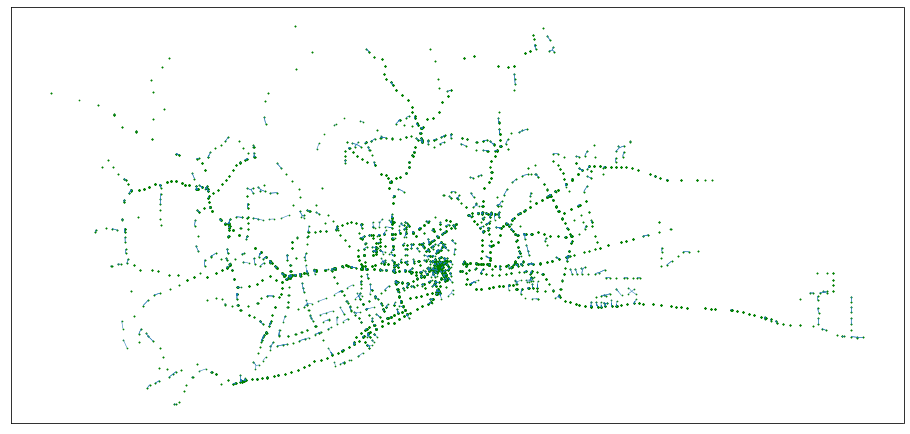

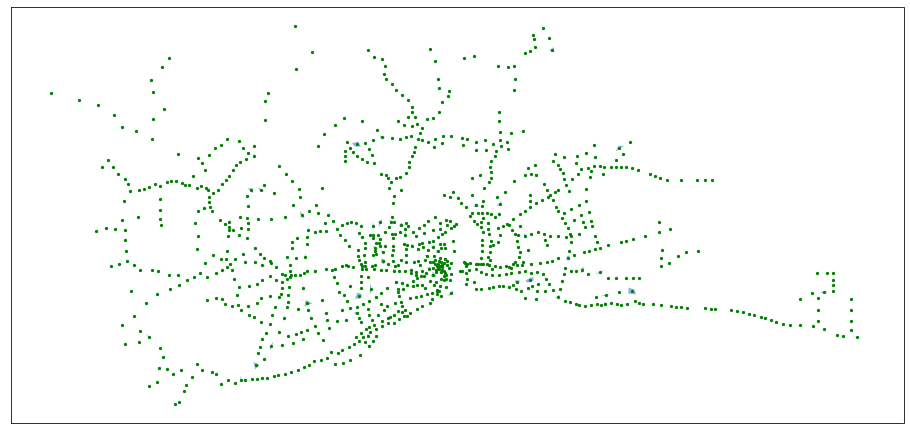

In [8]:
plot = sm.plot(
    'node_parenthood', linewidth=0.5,
    ax=sm.plot('disaggregated_nodes', figsize=[16, 9], markersize=0.5, color='green')
)
plot = sm.plot(
    'nodes', color='green', markersize=5,
    ax=sm.plot('node_clusters', figsize=[16, 9], alpha=0.5)
)

In [9]:
sm.integrity_test_circular_lines()

In [10]:
len(sm.links), len(disaggregated.links)

(10338, 13613)

# transport test

In [11]:
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()

dropped broken sequences: []


<AxesSubplot:>

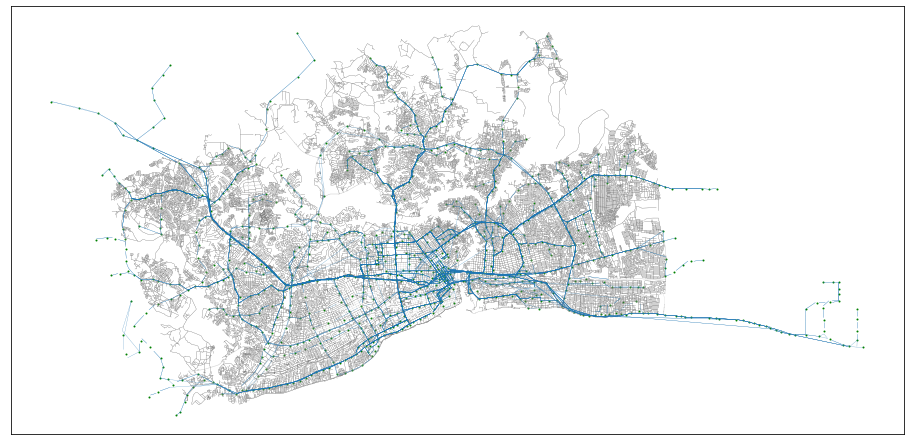

In [12]:
sm.plot(
    'links', linewidth=0.2, 
    ax=sm.plot('nodes', color='green', markersize=1,
    ax=sm.plot('road_links', figsize=[16, 9], linewidth=0.1, color='grey'))
)

# Networkcaster
à faire sur un réseau propre, avant l'agrégation

In [13]:
sm.integrity_test_all(errors='ignore', verbose=False)

50586it [00:09, 5297.94it/s]
50586it [00:23, 2110.81it/s]


In [14]:
sm.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=10, 
    n_neighbors=5
)

MB_M66B_1: 100%|██████████| 416/416 [03:20<00:00,  2.08it/s]  


No path between osm_node_7745055268 and osm_node_4156386090.
No path between osm_node_3942489959 and osm_node_1864844365.
No path between osm_node_7272578056 and osm_node_4156386090.
No path between osm_node_3942489969 and osm_node_3944381822.


In [15]:
sm.to_zip(
    training_folder + 'model/preparation/lines_networkcasted.zip',
    only_attributes=('links', 'nodes', 'epsg', 'coordinates_unit')
) 

jsons: 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


In [16]:
sm.analysis_lines()

<AxesSubplot:>

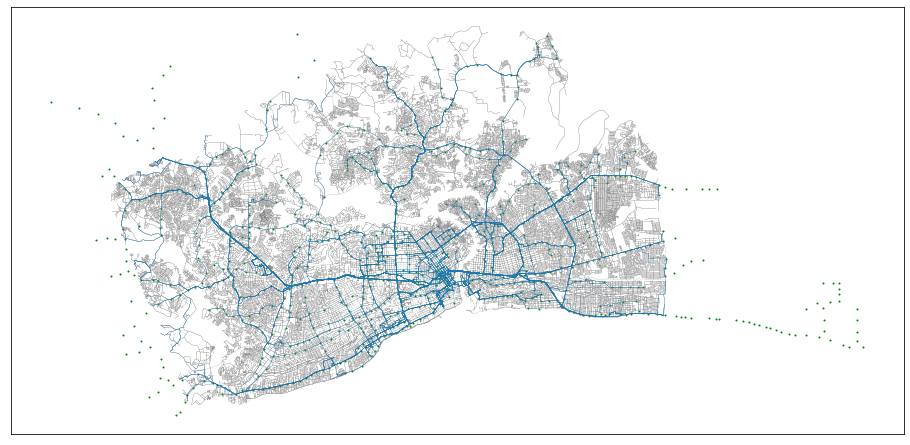

In [17]:
sm.plot(
    'links', linewidth=0.2, 
    ax=sm.plot('nodes', color='green', markersize=1,
    ax=sm.plot('road_links', figsize=[16, 9], linewidth=0.1, color='grey'))
)

In [18]:
road = sm.copy()
from shapely.geometry import LineString

links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

# summary
(lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int)

Deprecated: replaced by analysis_lines


link_straight_length    4012
straight_length         3003
length                  4483
dtype: int32

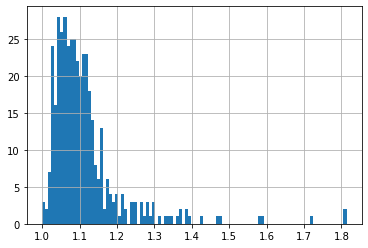

In [19]:
%matplotlib inline
ax = lines['length_ratio'].hist(bins=100)